<b><div style="text-align:right">Алексей Бебчик&nbsp;&nbsp;</div><b>
### Курс 6. Желтое такси. Неделя 7. Оформление проекта  
(задание, оцениваемое сокурсниками)




<a href="https://www.coursera.org/learn/data-analysis-project/peer/NHXek/oformlieniie-proiekta">Задание</a>

Определитесь, в каком виде вы хотите представить ваш проект. Мы предлагаем вам сделать интерактивное демо, содержащее:  
• карты с визуализацией реального и прогнозируемого спроса на такси в выбираемый пользователем момент времени;  
• временной ряд фактического и прогнозируемого спроса на такси в выбираемой области.  

Немного материалов о том, как в ноутбуках можно делать интерактивные графики:  
•https://blog.dominodatalab.com/interactive-dashboards-in-jupyter/  
•http://nbviewer.jupyter.org/github/quantopian/ipython/blob/master/examples/Interactive%20Widgets/Index.ipynb  
•https://github.com/ioam/holoviews  


Чтобы сдать задание, создайте демо и дайте ссылку на него.  

__Review criteria__ 

Демо будет оцениваться согласно реализованным компонентам.


In [3]:
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import binned_statistic_2d
import os                                     #для проверки существования файлов
import itertools
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model, ensemble, metrics
import datetime as dt
import timeit as ti
# from tqdm import tqdm_notebook, tqdm
from time import sleep

from datetime import date
# import holidays

%pylab inline

import geojson
# from   mpl_toolkits.basemap import Basemap
import folium

# pip intsall ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
from ipywidgets import widgets
from ipywidgets.widgets.widget_layout import Layout
from IPython.display import display
from IPython.display import clear_output
from collections import OrderedDict

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных
текст для подготовки данных внизу файла

In [5]:
data_path  = '..\\YTData\\'             #путь к папке с данными "K6w7_22" 
data4_path = '..\\YTweek4\\YTw4_data\\' #путь к папке с данными, неделя 4 
data6_path = '..\\YTweek6\\YTw6_data\\' #путь к папке с данными, неделя 6 
data7_path = 'YTw7_data\\'              #путь к папке с данными 

In [6]:
#Загружаем подготовленные данные из файла
data7 = pd.read_csv(data7_path + 'YTw7_data_pred_all.csv', 
                    parse_dates=['dt_hour', 'y_dt1', 'y_dt2', 'y_dt3', 'y_dt4', 'y_dt5', 'y_dt6'], dayfirst=True) 
data7['y_mae1'] = data7['y_delta1']
data7['y_mse1'] = data7['y_delta1']*data7['y_delta1']
data7.index = data7.dt_hour
data7.index.name = None 

In [7]:
#Загружаем районы
dfreg = pd.read_csv(data_path + 'regions.csv', sep=';') 
data_regs = data7.region.unique()
#Добавим столбецы с координатами центров районов
dfreg['lon'] = (dfreg.west  + dfreg.east)  / 2.0 #центр района
dfreg['lat'] = (dfreg.south + dfreg.north) / 2.0 #центр района

dfmdays = data7.groupby(['month'], as_index=False).day.max()
mon_days = dict(zip(dfmdays.month, dfmdays.day))
del dfmdays

#Параметры для первого блока
dic_prms0 = {}
dic_prms0['region'] = data_regs[0]
dic_prms0['year']  = 2016
dic_prms0['month'] = 1
#Параметры для второго блока
dic_prms1 = {}
dic_prms1['year']   = 2016
dic_prms1['month']  = 1
dic_prms1['day']    = 1
dic_prms1['hour']   = 1
dic_prms1['val']    = 'y_trips1' #{trips,pred,delta}
dic_prms1['info']   = 0

In [8]:
dic_month = {1:u'Январь', 2:u'Февраль', 3:u'Март', 4:u'Апрель', 5:u'Май', 6:u'Июнь', 
             7:u'Июль', 8:u'Август', 9:u'Сентябрь', 10:u'Октябрь', 11:u'Ноябрь', 12:u'Декабрь'}
#Для ipywidgets DropDown справочник обратный {значение:код}, а не {код:значение}
dic_val  = {'y_trips1':u'Поездки', 'y_pred1':u'Прогноз', 'y_mae1':'MAE', 'y_mse1':'MSE'}
dic_info = {u'Нет':0, u'Значение':1}
dic_valEng  = {'y_trips1':u'Trips', 'y_pred1':u'Prognoz', 'y_mae1':'MAE', 'y_mse1':'MSE'}
dic_val1 = OrderedDict(sorted(dict(zip(dic_val.values(), dic_val.keys())).items(), key=lambda x: x[1]))
dic_val_mon = OrderedDict(sorted(dict(zip(dic_month.values(), dic_month.keys())).items(), key=lambda x: x[1]))

## Формирование интеркативного графика по выбранному ряду
__Задаем район, месяц и нажимаем кнопку "Показать"__

<IPython.core.display.Javascript object>


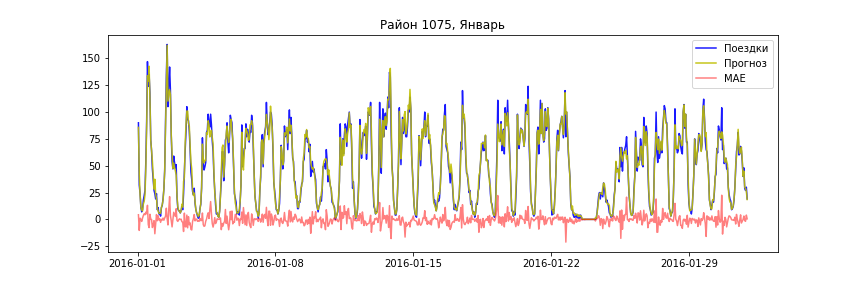

In [82]:
%matplotlib notebook
layout0     = Layout(width='150px')
prm_button0 = widgets.Button(description= u'Показать', layout = layout0)
prm_reg0    = widgets.Dropdown(options=list(data_regs), value=dic_prms0['region'], description=u'Регион', layout=layout0)
prm_month0  = widgets.Dropdown(options=dic_val_mon, value=dic_prms0['month'], description=u'Месяц', layout = layout0)
prm_list0   = [prm_button0, prm_reg0, prm_month0]
prm_container0 = widgets.HBox()
prm_container0.children = [i for i in prm_list0]
display(prm_container0)

plots = dict()
fig0, ax0 = plt.subplots(figsize=(12,4))
plt.show()

def prm_button0_on_click(sender):
    row_reg0   = dic_prms0['region']
    row_month0 = dic_prms0['month']
    row_data0  = data7[(data7.region==int(row_reg0))
                      &(data7.month==int(row_month0))][['y_trips1', 'y_pred1', 'y_mae1', 'y_mse1']]
    ax0.clear()
    plots, = ax0.plot(row_data0.index, row_data0.y_trips1, c='b', alpha=0.9, label= u'Поездки') 
    plots, = ax0.plot(row_data0.index, row_data0.y_pred1 , c='y', alpha=0.9, label= u'Прогноз')
    plots, = ax0.plot(row_data0.index, row_data0.y_mae1  , c='r', alpha=0.5, label= u'MAE')
    plt.legend(loc='upper right')
    plt.title(u'Район {}, {}'.format(row_reg0,dic_month[row_month0]))
    plt.draw()

def prm_reg0_on_cnaghe(change): 
    if change['type']=='change' and change['name'] == 'value': dic_prms0['region'] = change['new']

def prm_month0_on_cnaghe(change): 
    if change['type']=='change' and change['name'] == 'value': dic_prms0['month'] = change['new']

prm_button0.on_click(prm_button0_on_click)
prm_reg0.observe(prm_reg0_on_cnaghe)
prm_month0.observe(prm_month0_on_cnaghe)

plt.show()

## Формирование интеркативной карты по выбранному времени
__Задаем Месяц, День, Час и Типа значения (реальные поездки, прогзноз, ошибка прогноза) и нажимаем кнопку "Показать"__

### Подготовка для рисования карты

In [9]:
x0, x1, y0, y1 = -74.25559, -73.700018, 40.49612, 40.91553  #квадрат Нью-Йорка
cx, cy = (-74.25559+-73.700018)/2, (40.49612+40.91553)/2    #центр квадрата

regData_features = [] # Сформируем данные для показа на карте в формете GeoJSON

for i, row in dfreg.iterrows():
    #порядок имеет значение, нельзя просто сотсавлять любые пары
    reg_coord   = [(row.west, row.south), (row.west, row.north), (row.east, row.north), (row.east, row.south)]
    reg_poligon = geojson.Polygon([reg_coord])
    reg_feature = geojson.Feature(geometry=reg_poligon, id=row.region,
                                  properties={"name":row.region, "description":'reg'+str(row.region)})
    if row.region in (data_regs): regData_features.append(reg_feature) #есть данные

regData_features = geojson.FeatureCollection(regData_features)

In [10]:
def get_map_legend(): #возвращает подпись карты
    map_label = dic_val[dic_prms1['val']] + u' в '
    map_label += pd.datetime(dic_prms1['year'],
                             dic_prms1['month'], dic_prms1['day'], dic_prms1['hour']).strftime('%Y-%m-%d %H:%M')
    return map_label

In [12]:
#Данные в разбивках по регионам и ДатеВремени прогноза
data7map1 = data7.groupby(['region','y_dt1'], as_index=False)['y_trips1','y_pred1', 'y_delta1', 'y_mae1', 'y_mse1'].mean()

In [13]:
#Добавим в данные центр районов
data7map1['reg_lon'] = np.array(pd.merge(data7map1, dfreg, how='inner', on=['region'])[['lon']])
data7map1['reg_lat'] = np.array(pd.merge(data7map1, dfreg, how='inner', on=['region'])[['lat']])

In [14]:
data7map1[['region', 'reg_lon', 'reg_lat']] [:2]

,region,reg_lon,reg_lat
0,1075,-74.016691,40.701631
1,1075,-74.016691,40.701631


### Рисования карты

In [94]:
layout1     = Layout(width='150px')
prm_button1 = widgets.Button(description=u'Показать', layout = layout1)
prm_month1  = widgets.Dropdown(options=dic_val_mon        , value=dic_prms1['month'], description=u'Месяц', layout=layout1)
prm_day1    = widgets.Dropdown(options=list(range(1,31+1)), value=dic_prms1['day']  , description=u'День'  , layout=layout1)    
prm_hour1   = widgets.Dropdown(options=list(range(1,24+1)), value=dic_prms1['hour'] , description=u'Час'   , layout=layout1)
prm_val1    = widgets.Dropdown(options=dic_val1, value=dic_prms1['val']  , description=u'Данные'           , layout=layout1)
prm_info1   = widgets.Dropdown(options=dic_info, value=dic_prms1['info'] , description=u'Инфо'             , layout=layout1)
prm_list1   = [prm_button1, prm_month1, prm_day1, prm_hour1, prm_val1, prm_info1]
prm_container1 = widgets.HBox()
prm_container1.children = [i for i in prm_list1]

display(prm_container1)

prm_y_dt1 = pd.datetime(dic_prms1['year'],dic_prms1['month'], dic_prms1['day'], dic_prms1['hour'])
m = folium.Map(location=[cy, cx], zoom_start=11, tiles='Stamen Toner')
m.choropleth(
    geo_data     = regData_features,
    name         = 'choropleth',
    data         = data7map1[data7map1.y_dt1 == prm_y_dt1],
    columns      = ['region', dic_prms1['val']],
    key_on       = 'feature.id',
    fill_color   = 'YlOrRd', 
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name  = get_map_legend()
)
    
m.add_child(folium.LatLngPopup()) #при клики показываются координаты

display(m)

def prm_button1_on_click(sender):
    prm_y_dt1 = pd.datetime(dic_prms1['year'],dic_prms1['month'], dic_prms1['day'], dic_prms1['hour'])
    m = folium.Map(location=[cy, cx], zoom_start=11, tiles='Stamen Toner')
    m.add_child(folium.LatLngPopup()) #при клики показываются координаты    
    m.choropleth(
    geo_data     = regData_features,
    name         = 'choropleth',
    data         = data7map1[data7map1.y_dt1 == prm_y_dt1],
    columns      = ['region', dic_prms1['val']],
    key_on       = 'feature.id',
    fill_color   = 'YlOrRd', 
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name  = get_map_legend()
    )

    #Добавим на карту информацию районах (Поездки, Прогноз, MAE, MSE)  
    if dic_prms1['info'] == 1:
        for i, r in data7map1[data7map1.y_dt1 == prm_y_dt1].iterrows():
            show_val  = str(int(r[dic_prms1['val']]))
            popup_val = str(int(r.region))
            folium.Marker(location=[r.reg_lat,r.reg_lon],
                          popup=(folium.Popup(popup_val)), 
                          icon= folium.DivIcon(icon_size=(10,10), icon_anchor=(1,1),
                                               html='<div style="font-size: 8pt; color : black">'+show_val+'</div>')).add_to(m)

    clear_output(wait=True) #очищаем предыдущее изображение  

#     display(prm_container1) #!!! ВНИМАНИЕ: ЕСЛИ ПРИ НАЖАТИИ "ПОКАЗАТЬ" ПРОПАДАЕТ ПАНЕЬ С ПАРАМЕТРАМИ, ОТКРЫТЬ ЭТУ СТРОКУ !!!

    display(m)              #рисуем новое 
    
def prm_month1_on_cnaghe(change): 
    if change['type']=='change' and change['name'] == 'value': dic_prms1['month'] = change['new']
def prm_day1_on_cnaghe(change): 
    if change['type']=='change' and change['name'] == 'value': dic_prms1['day'] = change['new']
def prm_hour1_on_cnaghe(change): 
    if change['type']=='change' and change['name'] == 'value': dic_prms1['hour'] = change['new']
def prm_val1_on_cnaghe(change): 
    if change['type']=='change' and change['name'] == 'value': dic_prms1['val'] = change['new']
def prm_info1_on_cnaghe(change): 
    if change['type']=='change' and change['name'] == 'value': dic_prms1['info'] = change['new']

prm_button1.on_click(prm_button1_on_click)
prm_month1.observe(prm_month1_on_cnaghe)
prm_day1.observe(prm_day1_on_cnaghe)
prm_hour1.observe(prm_hour1_on_cnaghe)
prm_val1.observe(prm_val1_on_cnaghe)
prm_info1.observe(prm_info1_on_cnaghe)

### Обработка данных 6-й недели

In [2]:
def print_time(label='now'):
    print label, dt.datetime.now().strftime('%H:%M')
def MAE(prm_y, prm_y_pred):
    return metrics.mean_absolute_error(prm_y, prm_y_pred)

In [148]:
train_endtime = '2016.04.30 17:00'
tune_begtime  = '2016.04.30 23:00'
tune_endtime  = '2016.05.31 17:00'
test_begtime  = '2016.05.31 23:00'
test_endtime  = '2016.06.30 17:00'

data6fin = pd.read_csv(data_path4 + 'YTw4_data6_fin.csv', parse_dates=['dt_hour'], dayfirst=True) #Загружаем данные из файла
data6fin.index = data7.dt_hour
data6fin.index.name = None

# Загрузим список категориальных столбцов (5-я неделя)
pd_cat_cols = pd.read_csv(data_path6 + 'YTw6_cat_cols.csv')
cols_main_cat = list(pd_cat_cols.col.values) #категормальные переменные
cols_y = ['y1','y2','y3','y4','y5','y6']     #столбцы с прогнозом

cols_drop = ['dt_hour']+cols_y
X_train = data6fin.drop(cols_drop, axis=1)[:train_endtime]
X_test  = data6fin.drop(cols_drop, axis=1)[test_begtime:test_endtime]

y_train, y_tune, y_test = [], [], []
for col in cols_y:
    y_train.append(data6fin[[col]][:train_endtime])
    y_test.append(data6fin[[col]][test_begtime:test_endtime])

In [60]:
%time 
rf_list       = [] #модели
fin_pred_list = []
rfQtest_list  = []
fin_save_list = []

for i in range(6):
    print i, 
    rf = ensemble.RandomForestRegressor() 
    rf.fit(X_train,y_train[i])
    rf_list.append(rf)    
    fin_pred = rf_list[i].predict(X_test)
    fin_pred_list.append(fin_pred)
    rfQtest_list.append(MAE(y_test[i], fin_pred))

In [150]:
print 'Ошибка прогноза:', sum(rfQtest_list) / 6

Ошибка прогноза: 19.5121415513


In [271]:
cols_drop = ['dt_hour']+cols_y
X_all = data6fin.drop(cols_drop, axis=1)
y_all = []
for col in cols_y:
    y_all.append(data6fin[[col]])

In [272]:
all_pred_list = []
all_rfQ_list = []
for i in range(6):
    print i, 
    rfx = rf_list[i]
    all_pred = rfx.predict(X_all)
    all_pred_list.append(all_pred)
    all_rfQ_list.append(MAE(y_all[i], all_pred))

0 1 2 3 4 5


In [277]:
print 'Ошибка прогноза (все месяцы):', sum(all_rfQ_list) / 6

Ошибка прогноза (все месяцы): 11.3972885409


In [275]:
data7all = data6fin[['region', 'dt_hour', 'year', 'month', 'hour', 'trips']].copy()
data7all['year']  = data7all.year.astype(int)
data7all['month'] = data7all.month.astype(int)
data7all['hour']  = data7all.hour.astype(int)
data7all['day']   = data7all.dt_hour.dt.day
for i in range(6):
    all_pred = all_pred_list[i]
    all_delta = np.array(y_all[i]).ravel() - all_pred
    data7all.loc[:,'y_trips'+str(i+1)] = np.array(y_all[i]).ravel()
    data7all.loc[:,'y_pred'+str(i+1)]  = all_pred
    data7all.loc[:,'y_delta'+str(i+1)] = all_delta 
    data7all.loc[:,'y_delta_abs'+str(i+1)] = map(abs, all_delta) 
    data7all.loc[:,'y_dt'+str(i+1)] = data7all.dt_hour + pd.Timedelta(hours=i) #предыдущая дата

In [276]:
data7all.to_csv(data7_path + 'YTw7_data_pred_all.csv', index=False)  #сохраняем признаки

In [ ]:
data70 = pd.read_csv(data7_path + 'YTw7_data_pred_all0.csv', parse_dates=['dt_hour'], dayfirst=True) #Загружаем подготовленные данные
cols_70 = ['region', 'dt_hour', 'year', 'month', 'hour', 'trips', 'day', 'y_trips0', 'y_pred0', 'y_delta0', 'y_delta_abs0', 'y_trips1', 'y_pred1', 'y_delta1', 'y_delta_abs1', 'y_trips2', 'y_pred2', 'y_delta2', 'y_delta_abs2', 'y_trips3', 'y_pred3', 'y_delta3', 'y_delta_abs3', 'y_trips4', 'y_pred4', 'y_delta4', 'y_delta_abs4', 'y_trips5', 'y_pred5', 'y_delta5', 'y_delta_abs5']
cols_71 = ['region', 'dt_hour', 'year', 'month', 'hour', 'trips', 'day', 'y_trips1', 'y_pred1', 'y_delta1', 'y_delta_abs1', 'y_trips2', 'y_pred2', 'y_delta2', 'y_delta_abs2', 'y_trips3', 'y_pred3', 'y_delta3', 'y_delta_abs3', 'y_trips4', 'y_pred4', 'y_delta4', 'y_delta_abs4', 'y_trips5', 'y_pred5', 'y_delta5', 'y_delta_abs5', 'y_trips6', 'y_pred6', 'y_delta6', 'y_delta_abs6']
data70.columns = cols_71
for i in range(6):
    data70.loc[:,'y_dt'+str(i+1)] = data70.dt_hour + pd.Timedelta(hours=i) #предыдущая дата
data70.to_csv(data7_path + 'YTw7_data_pred_all.csv', index=False)          #сохраняем признаки